In [2]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, BatchNormalization
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, Flatten, Activation

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess 

from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model 

import os
import matplotlib.pyplot as plt 

2023-06-09 17:11:39.252397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 17:11:39.403379: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-09 17:11:40.211127: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:/home/fashr003/anaconda3/lib/:/home/fashr00

In [3]:
## CREATE Train, Val and Test DATASETS

IMAGE_SIZE = (224, 340)
CROP_SIZE = (224, 224)
BATCH_SIZE = 128

def dataset(ds_path, image_size=IMAGE_SIZE, crop_size=CROP_SIZE, batch_size=BATCH_SIZE, 
            train_split=0.7, val_split=0.1, test_split=0.2):
    # Create the image dataset
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=True, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)
    
    # Calculate the number of samples for each split
    num_samples = len(ds)
    num_train_samples = int(num_samples * train_split)
    num_val_samples = int(num_samples * val_split)
    num_test_samples = num_samples - num_train_samples - num_val_samples
    
    # Split the dataset
    ds_train = ds.take(num_train_samples)
    ds_val = ds.skip(num_train_samples).take(num_val_samples)
    ds_test = ds.skip(num_train_samples + num_val_samples).take(num_test_samples)

    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)

    @tf.function
    def augment(images, labels):
        aug_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,
                                                               [image],
                                                               tf.float32), 
                               images)
        aug_images = tf.ensure_shape(aug_images, images.shape)
        return aug_images, labels

    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)

    @tf.function
    def crop(images, labels):
        cropped_images = crop_layer(images, training=True)
        return cropped_images, labels

    ds_train = ds_train.map(augment, tf.data.experimental.AUTOTUNE)
    ds_train = ds_train.map(crop, tf.data.experimental.AUTOTUNE)
    ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

    ds_val = ds_val.map(crop, tf.data.experimental.AUTOTUNE)
    ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE)

    ds_test = ds_test.map(crop, tf.data.experimental.AUTOTUNE)
    ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

    return ds_train, ds_val, ds_test 



In [4]:
def naive_inception_module(layer_in, f1, f2, f3):
        # 1x1 conv
        conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
        # 3x3 conv
        conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
        # 5x5 conv
        conv5 = Conv2D(f3, (5,5), padding='same', activation='relu')(layer_in)
        # 3x3 max pooling
        pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
        # concatenate filters, assumes filters/channels last
        layer_out = Concatenate()([conv1, conv3, conv5, pool])
        return layer_out

In [5]:
def plot_train_history(train_history, init_epochs, title=""):
    from matplotlib import pyplot as plt
    plt.style.use("ggplot") 

    acc = train_history.history['accuracy']
    val_acc = train_history.history['val_accuracy']

    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']

    fig = plt.figure(figsize=(16, 4))
    fig.patch.set_alpha(0.5)

    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
    plt.legend(['Training Accuracy', 'Validation Accuracy', 'Start Fine Tuning'],
            loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(title) 

    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.plot([init_epochs - 1, init_epochs - 1], plt.ylim())
    plt.legend(['Training Loss', 'Validation Loss', 'Start Fine Tuning'],
            loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.xlabel('Epochs')
    plt.title(title) 
    #plt.savefig("ResNet50/Figures/training_plot1.png")
    plt.show()

In [6]:
def eval_model(model, test_loader, title):
    import numpy as np
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 
    from scikitplot.metrics import plot_confusion_matrix, plot_roc

    y_true, y_pred = [], []
    for images, labels in test_loader:
        preds = model.predict(images)
        y_true.append(labels.numpy())
        y_pred.append(preds)

    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    y_probas = y_pred
    y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
    print('Accuracy: ', accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    
    plot_confusion_matrix(y_true, y_pred, title=title)
    plot_confusion_matrix(y_true, y_pred, normalize=True, title=title) 
    plot_roc(y_true, y_probas, title=title) 


In [7]:

base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))
base_model.summary()
# Print the layers and their names
print("ResNet50 Layers:")
for i, layer in enumerate(base_model.layers):
    print(f"Layer {i}: {layer.name}")

2023-06-09 17:11:51.892082: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-06-09 17:11:51.892130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ubuntu
2023-06-09 17:11:51.892136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ubuntu
2023-06-09 17:11:51.892268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.105.1
2023-06-09 17:11:51.892297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.86.1
2023-06-09 17:11:51.892302: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 515.86.1 does not match DSO version 515.105.1 -- cannot find working devices in this configuration
2023-06-09 17:11:51.

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [8]:
def resnet50_only(train=False):
    base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))

    layer_name = 'conv5_block3_out'
    feature_ex_model = tf.keras.Model(inputs=base_model.input, 
                                      outputs=base_model.get_layer(layer_name).output, 
                                      name='resnet50_features')
    feature_ex_model.trainable = train

    p1_layer = tf.keras.layers.Lambda(resnet50_preprocess, name='resnet50_Preprocess')
    image_input = tf.keras.Input((224, 224, 3), name='Image_Input')
    p1_tensor = p1_layer(image_input)

    out = feature_ex_model(p1_tensor)
    feature_ex_model = tf.keras.Model(inputs=image_input, outputs=out)

    #out = naive_inception_module(feature_ex_model.output, 64, 128, 32)

   # bn1 = tf.keras.layers.BatchNormalization(name='BN')(out)
    f = tf.keras.layers.Flatten()(feature_ex_model.output) 
   # dropout = tf.keras.layers.Dropout(0.4, name='Dropout')(f)
    desne = tf.keras.layers.Dense(2, activation='softmax', name='Predictions')(f)
    model = tf.keras.Model(inputs=feature_ex_model.input, outputs=desne)
    return model


In [9]:
def model_dataset_epoch(model, train_set, val_set, test_set, epoch, folder_path, plot_title=""):
    # Define optimizer, Compile model, Define callbacks, Train the model
    opt = keras.optimizers.Adam(learning_rate=0.001) 
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) 

    callbacks = [
        ModelCheckpoint(monitor='val_accuracy',filepath=folder_path+"model-weights.{epoch:02d}-{val_accuracy:.6f}.hdf5", verbose=1, save_best_only=True),
        tf.keras.callbacks.TensorBoard(log_dir=folder_path+'tb_logdir/')
    ]
    init_epochs = epoch
    train_history = model.fit(train_set, epochs=init_epochs, validation_data=val_set, verbose=1, callbacks=callbacks) 

    plot_train_history(train_history, init_epochs=init_epochs, title=plot_title)  

    # Load best saved model
    files = os.listdir(folder_path) 
    files.sort(key=lambda x: os.path.getmtime(os.path.join(folder_path, x)))
    last_file = files[-1]
    model_path = folder_path+last_file  
    print('Best model path: ', model_path)
    best_model = load_model(model_path)

    # Evaluate the best model 
    best_model.evaluate(test_set)   
    eval_model(best_model, test_set, title=plot_title) 

## **ResNet50(Pretrained)**

### **400X images**

Found 1820 files belonging to 2 classes.
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_Input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50_Preprocess (Lambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50_features (Function  (None, 7, 7, 2048)       23587712  
 al)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 Predictions (Dense)         (None, 2)                 200706    
                                                                 
Total params: 23,7

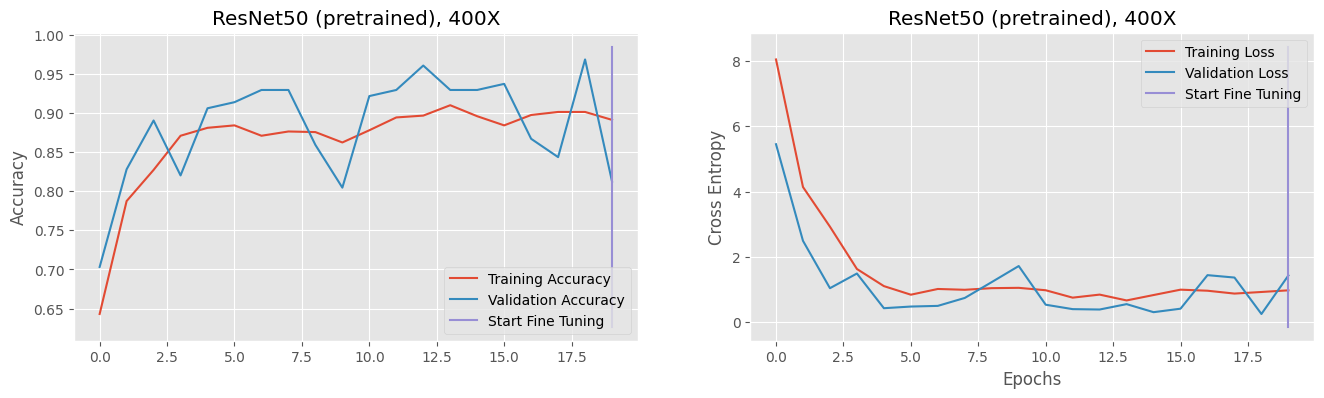

Best model path:  ResNet50_pretrained/400X/model-weights.19-0.968750.hdf5
1/1 [==============================] - 1s 1s/step
Accuracy:  0.9344660194174758
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       139
           1       0.93      0.98      0.95       273

    accuracy                           0.93       412
   macro avg       0.94      0.91      0.92       412
weighted avg       0.94      0.93      0.93       412



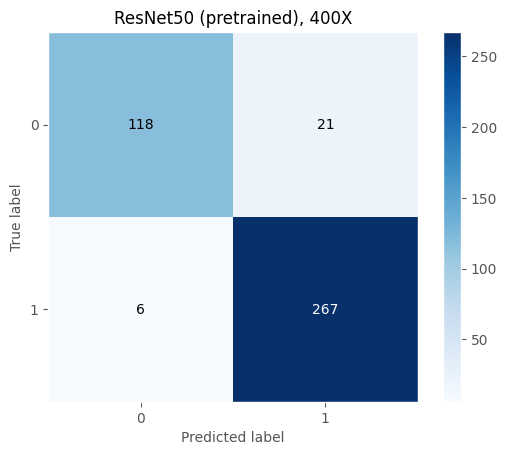

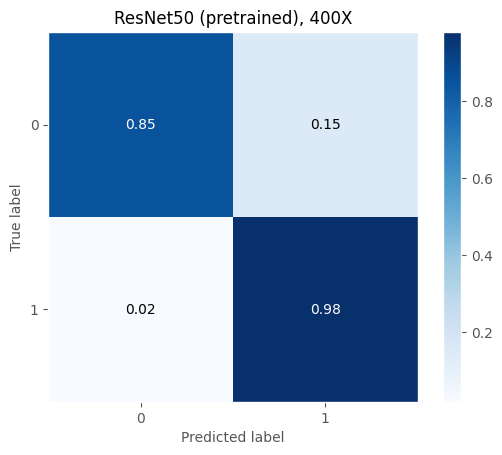

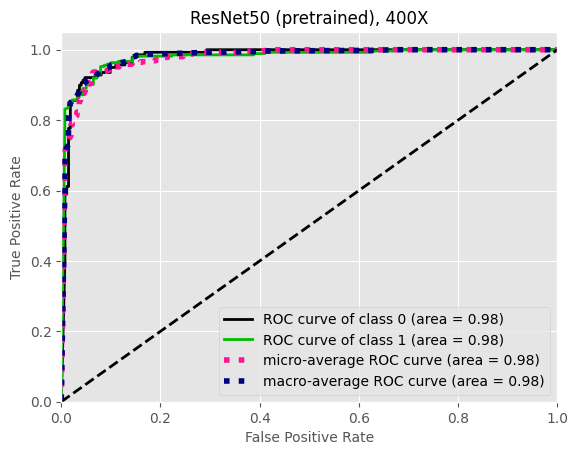

In [22]:
# Create dataset train, val, test 
train_400x, val_400x, test_400x = dataset('400/') 

folder_resnet50_pretrained_400x = "ResNet50_pretrained/400X/"
model = resnet50_only() 
model.summary() 

model_dataset_epoch(model, train_400x, val_400x, test_400x, epoch=20, folder_path=folder_resnet50_pretrained_400x,
                    plot_title="ResNet50 (pretrained), 400X")  

### **40X images**

Found 1995 files belonging to 2 classes.
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_Input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50_Preprocess (Lambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50_features (Function  (None, 7, 7, 2048)       23587712  
 al)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 Predictions (Dense)         (None, 2)                 200706    
                                                                 
Total params: 23,7

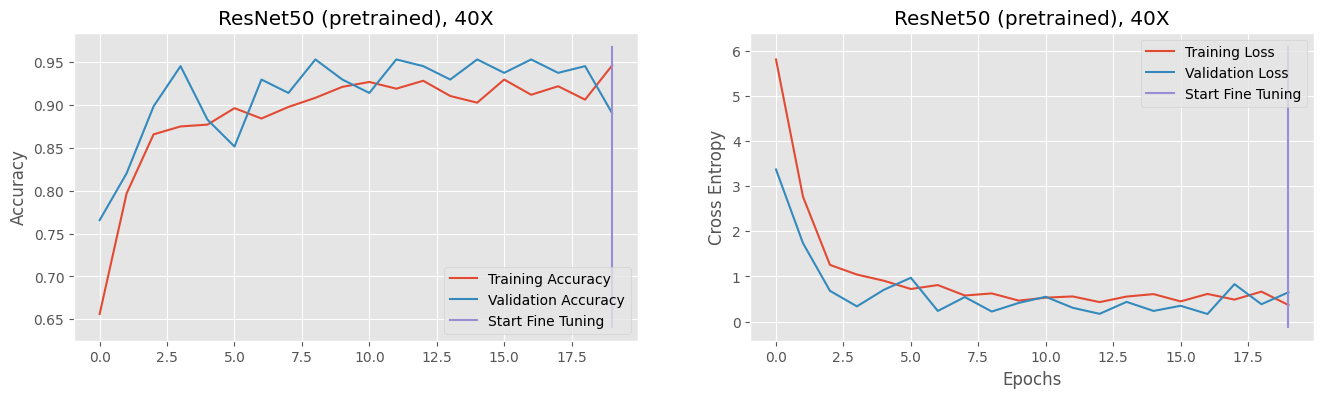

Best model path:  ResNet50_pretrained/40X/model-weights.09-0.953125.hdf5
3/3 [==============================] - 2s 253ms/step
Accuracy:  0.9455337690631809
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       118
           1       0.96      0.97      0.96       341

    accuracy                           0.95       459
   macro avg       0.93      0.92      0.93       459
weighted avg       0.95      0.95      0.95       459



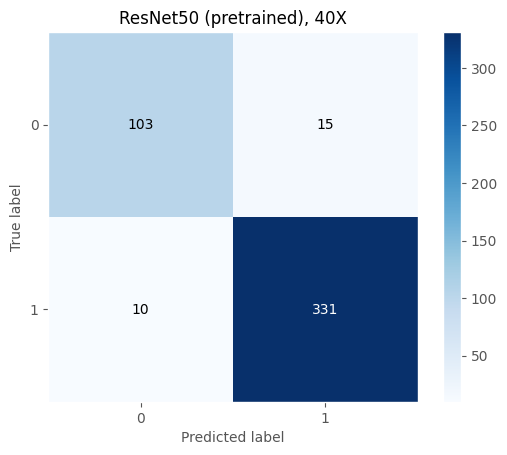

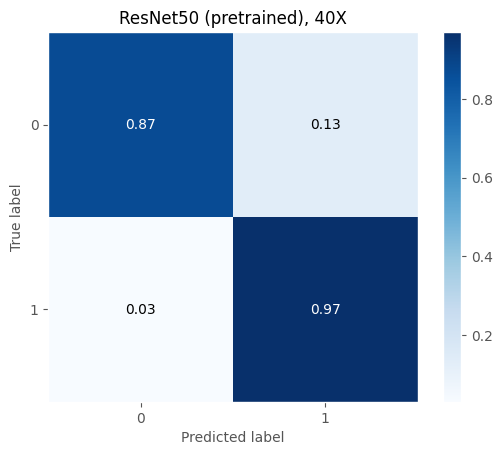

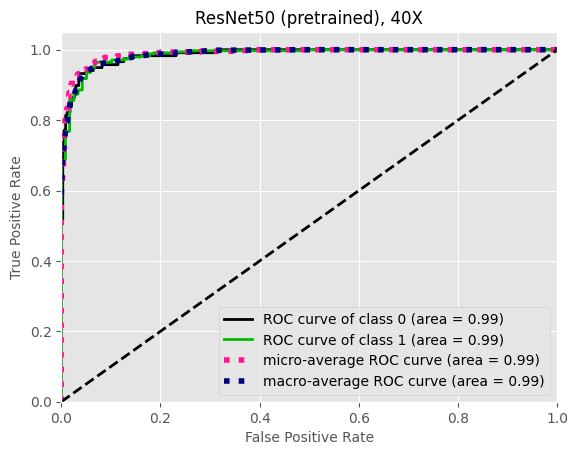

In [23]:
# Create dataset train, val, test 
train_40x, val_40x, test_40x = dataset('40/') 

folder_resnet50_pretrained_40x = "ResNet50_pretrained/40X/"
model = resnet50_only() 
model.summary() 

model_dataset_epoch(model, train_40x, val_40x, test_40x, epoch=20, folder_path=folder_resnet50_pretrained_40x,
                    plot_title="ResNet50 (pretrained), 40X")

### **100X images**

Found 2081 files belonging to 2 classes.
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_Input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50_Preprocess (Lambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50_features (Function  (None, 7, 7, 2048)       23587712  
 al)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 100352)            0         
                                                                 
 Predictions (Dense)         (None, 2)                 200706    
                                                                 
Total params: 23,

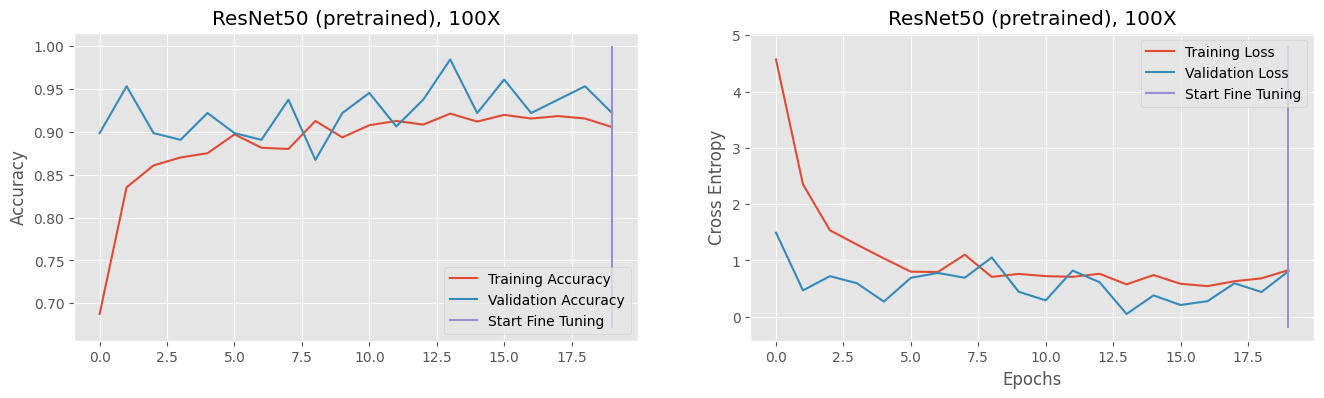

Best model path:  ResNet50_pretrained/100X/model-weights.14-0.984375.hdf5
2/2 [==============================] - 1s 95ms/step
Accuracy:  0.944954128440367
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       158
           1       0.95      0.97      0.96       387

    accuracy                           0.94       545
   macro avg       0.94      0.93      0.93       545
weighted avg       0.94      0.94      0.94       545



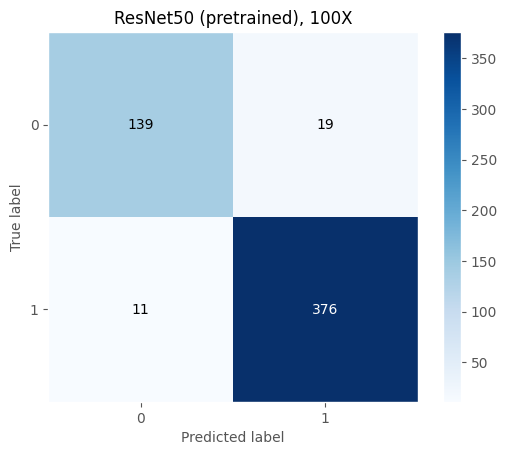

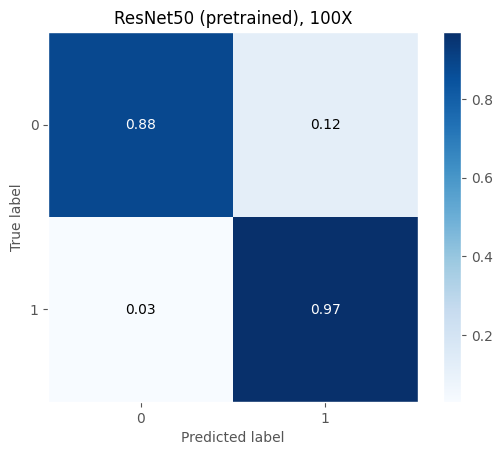

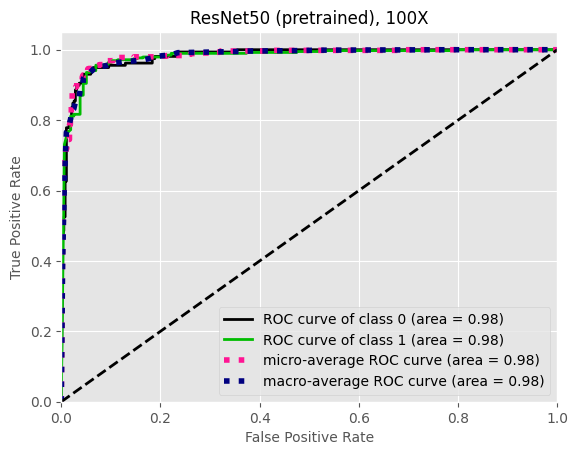

In [24]:
# Create dataset train, val, test 
train_100x, val_100x, test_100x = dataset('100/') 

folder_resnet50_pretrained_100x = "ResNet50_pretrained/100X/"
model = resnet50_only() 
model.summary() 

model_dataset_epoch(model, train_100x, val_100x, test_100x, epoch=20, folder_path=folder_resnet50_pretrained_100x,
                    plot_title="ResNet50 (pretrained), 100X")

### **200X**

Found 2013 files belonging to 2 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_Input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50_Preprocess (Lambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50_features (Function  (None, 7, 7, 2048)       23587712  
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 100352)            0         
               

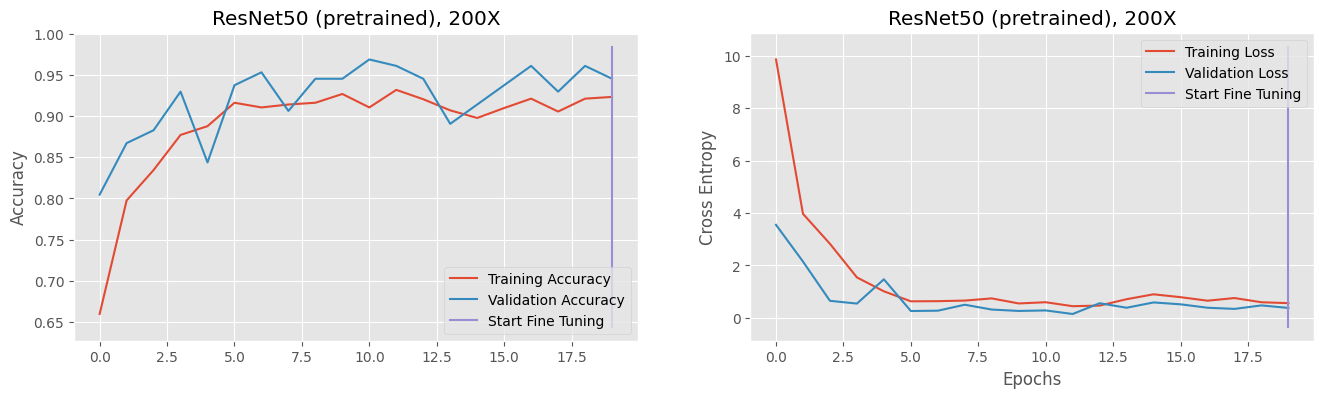

Best model path:  ResNet50_pretrained/200X/model-weights.11-0.968750.hdf5
3/3 [==============================] - 2s 312ms/step
Accuracy:  0.9308176100628931
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       155
           1       0.96      0.93      0.95       322

    accuracy                           0.93       477
   macro avg       0.92      0.93      0.92       477
weighted avg       0.93      0.93      0.93       477



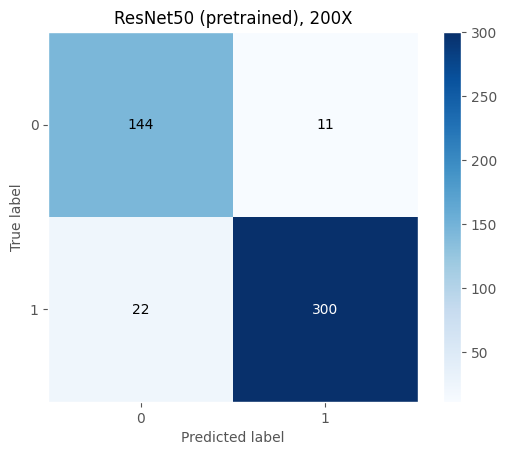

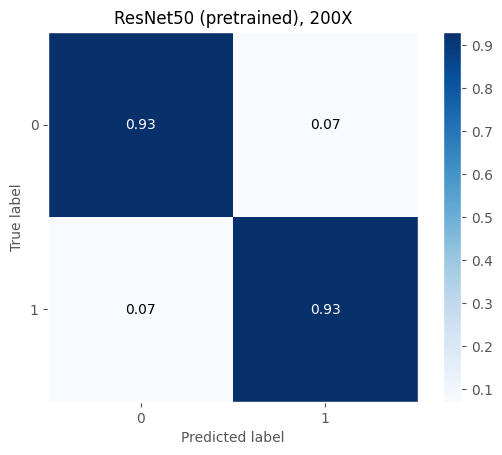

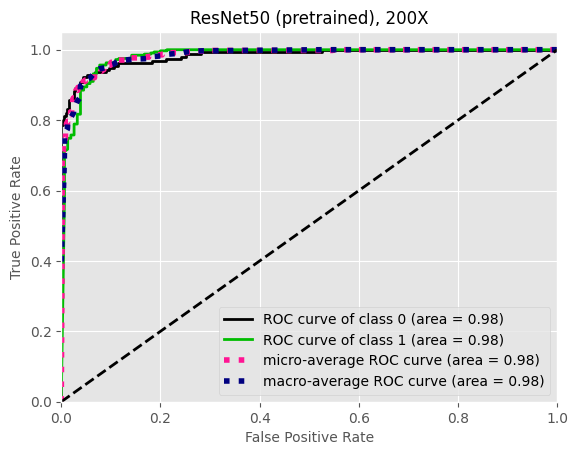

In [10]:
# Create dataset train, val, test 
train_200x, val_200x, test_200x = dataset('200/') 

folder_resnet50_pretrained_200x = "ResNet50_pretrained/200X/"
model = resnet50_only() 
model.summary() 

model_dataset_epoch(model, train_200x, val_200x, test_200x, epoch=20, folder_path=folder_resnet50_pretrained_200x,
                    plot_title="ResNet50 (pretrained), 200X") 

## **ResNet50 (Trained)**

### **400X** 

Found 1820 files belonging to 2 classes.
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_Input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50_Preprocess (Lambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50_features (Function  (None, 7, 7, 2048)       23587712  
 al)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 100352)            0         
                                                                 
 Predictions (Dense)         (None, 2)                 200706    
                                                                 
Total params: 23,

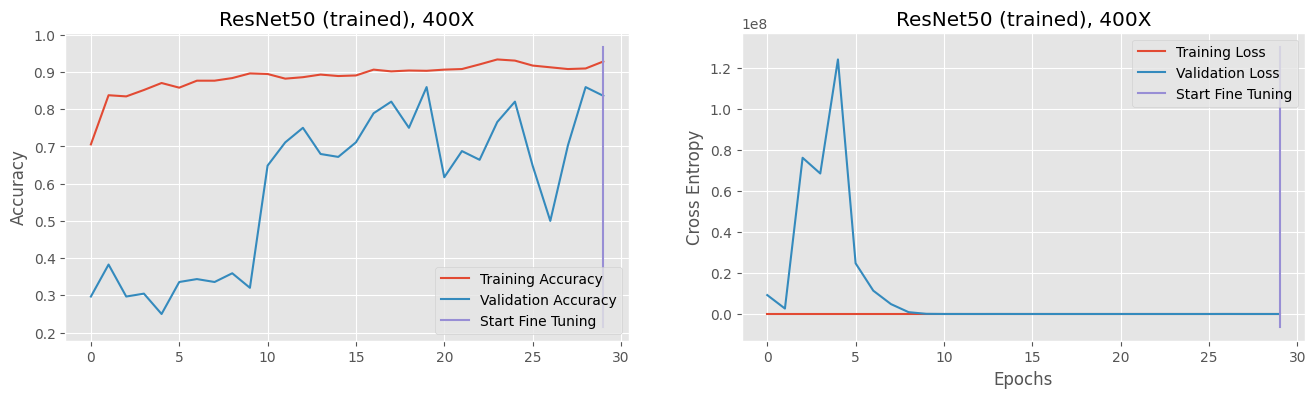

Best model path:  ResNet50_trained/400X/model-weights.20-0.859375.hdf5
1/1 [==============================] - 1s 1s/step
Accuracy:  0.8325242718446602
              precision    recall  f1-score   support

           0       0.81      0.65      0.72       137
           1       0.84      0.92      0.88       275

    accuracy                           0.83       412
   macro avg       0.83      0.79      0.80       412
weighted avg       0.83      0.83      0.83       412



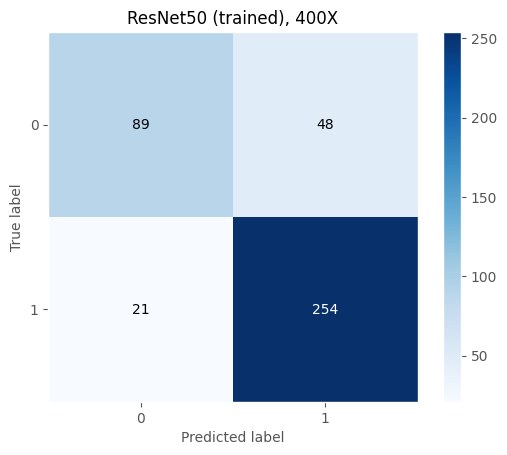

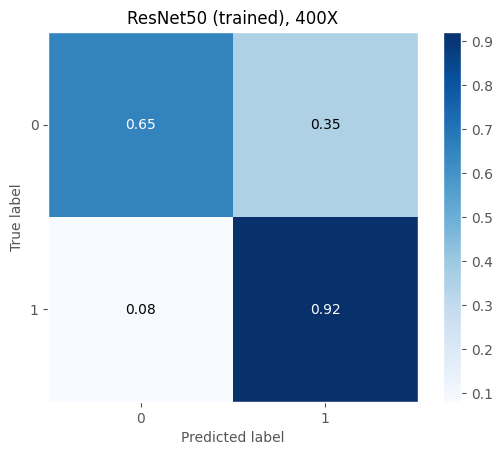

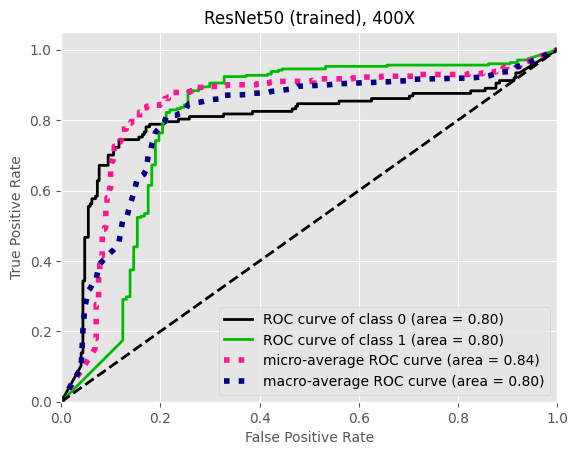

In [25]:
# Create dataset train, val, test 
train_400x, val_400x, test_400x = dataset('400/') 

folder_path_resnet50_trained_400x = "ResNet50_trained/400X/"

model = resnet50_only(train=True) 
model.summary() 

model_dataset_epoch(model, train_400x, val_400x, test_400x, epoch=30, folder_path=folder_path_resnet50_trained_400x,
                    plot_title="ResNet50 (trained), 400X") 


### **40X**

Found 1995 files belonging to 2 classes.
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_Input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50_Preprocess (Lambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50_features (Function  (None, 7, 7, 2048)       23587712  
 al)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 100352)            0         
                                                                 
 Predictions (Dense)         (None, 2)                 200706    
                                                                 
Total params: 23,

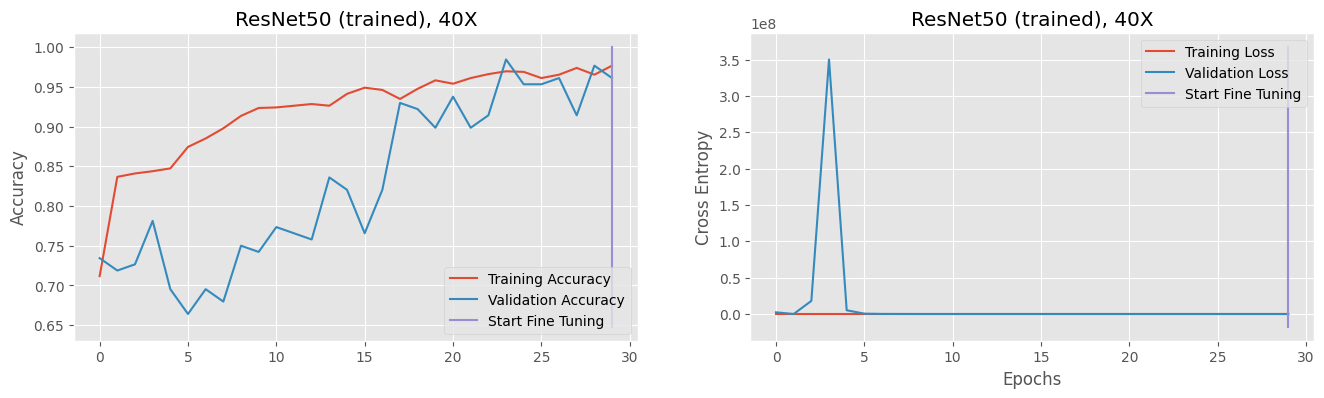

Best model path:  ResNet50_trained/40X/model-weights.24-0.984375.hdf5
3/3 [==============================] - 2s 245ms/step
Accuracy:  0.9498910675381264
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       157
           1       0.95      0.97      0.96       302

    accuracy                           0.95       459
   macro avg       0.95      0.94      0.94       459
weighted avg       0.95      0.95      0.95       459



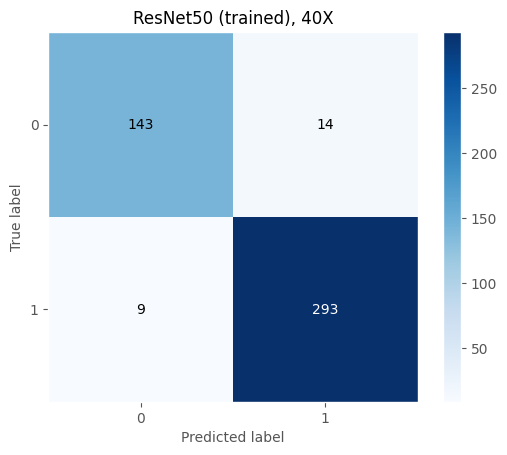

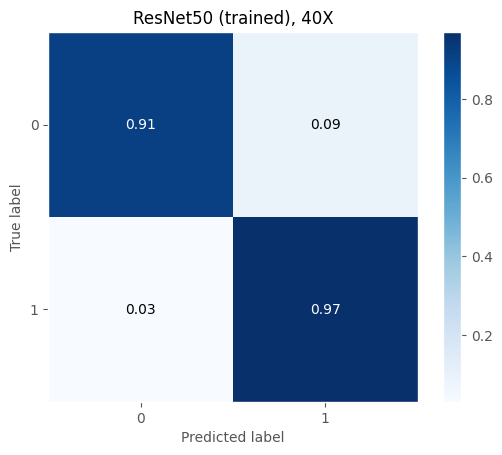

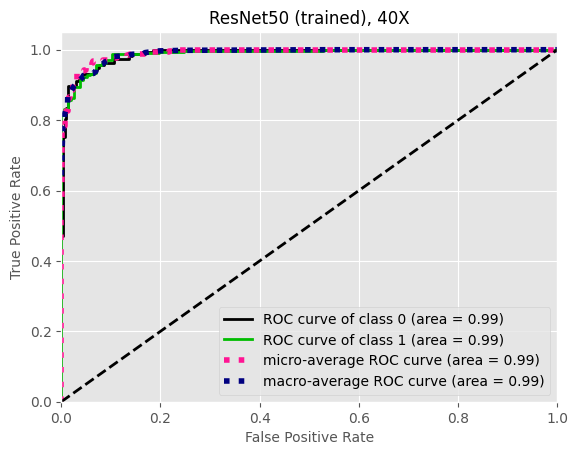

In [26]:
# Create dataset train, val, test 
train_40x, val_40x, test_40x = dataset('40/') 

folder_path_resnet50_trained_40x = "ResNet50_trained/40X/"

model = resnet50_only(train=True) 
model.summary() 

model_dataset_epoch(model, train_40x, val_40x, test_40x, epoch=30, folder_path=folder_path_resnet50_trained_40x,
                    plot_title="ResNet50 (trained), 40X")  

### **100X**

Found 2081 files belonging to 2 classes.
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_Input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50_Preprocess (Lambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50_features (Function  (None, 7, 7, 2048)       23587712  
 al)                                                             
                                                                 
 flatten_8 (Flatten)         (None, 100352)            0         
                                                                 
 Predictions (Dense)         (None, 2)                 200706    
                                                                 
Total params: 23,

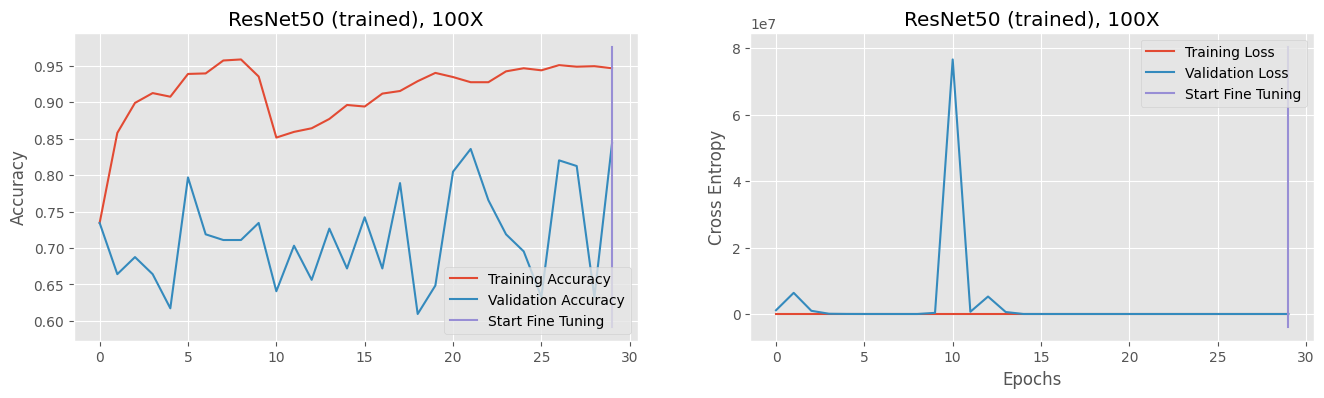

Best model path:  ResNet50_trained/100X/model-weights.30-0.843750.hdf5
2/2 [==============================] - 1s 77ms/step
Accuracy:  0.8532110091743119
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       179
           1       0.90      0.88      0.89       366

    accuracy                           0.85       545
   macro avg       0.83      0.84      0.84       545
weighted avg       0.86      0.85      0.85       545



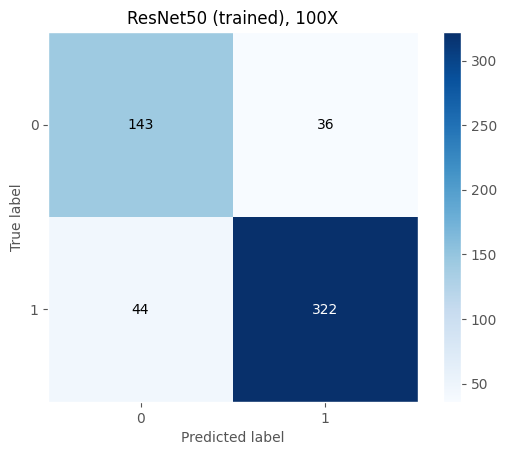

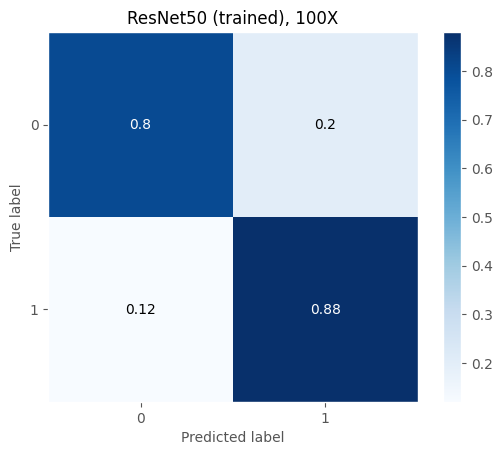

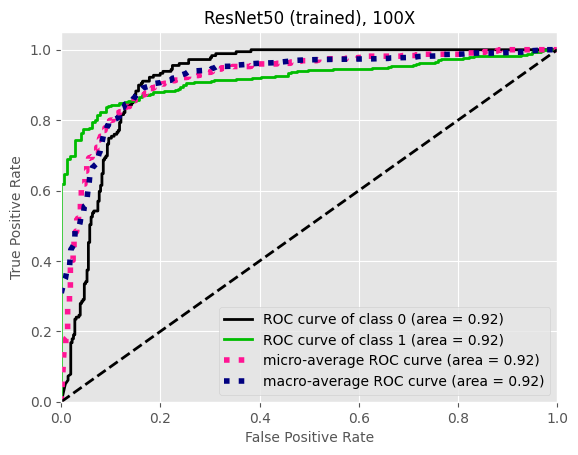

In [27]:
# Create dataset train, val, test 
train_100x, val_100x, test_100x = dataset('100/') 

folder_path_resnet50_trained_100x = "ResNet50_trained/100X/"

model = resnet50_only(train=True) 
model.summary() 

model_dataset_epoch(model, train_100x, val_100x, test_100x, epoch=30, folder_path=folder_path_resnet50_trained_100x,
                    plot_title="ResNet50 (trained), 100X") 

### **200X** 

Found 2013 files belonging to 2 classes.
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_Input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50_Preprocess (Lambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50_features (Function  (None, 7, 7, 2048)       23587712  
 al)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 Predictions (Dense)         (None, 2)                 200706    
                                                                 
Total params: 23,7

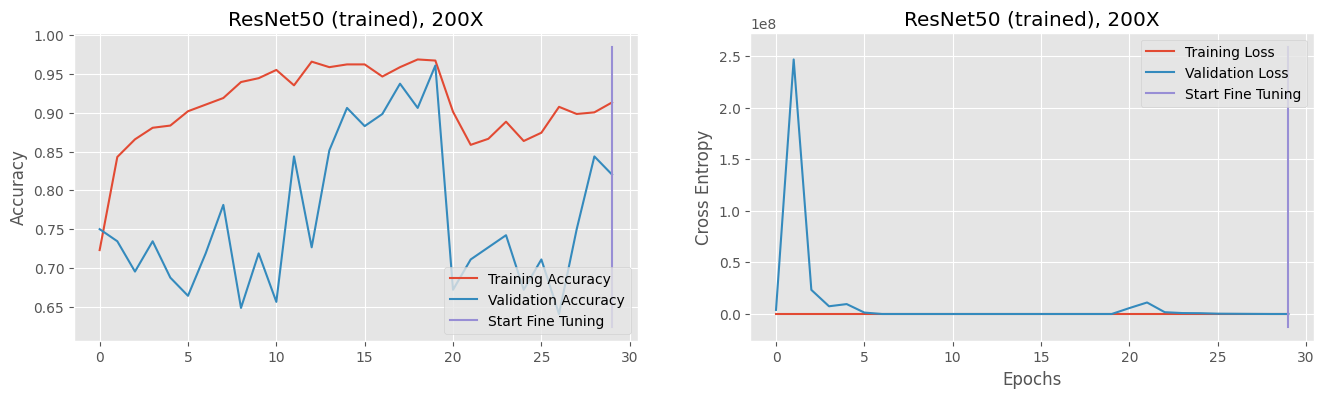

Best model path:  ResNet50_trained/200X/model-weights.20-0.960938.hdf5
3/3 [==============================] - 2s 299ms/step
Accuracy:  0.9287211740041929
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       145
           1       0.92      0.98      0.95       332

    accuracy                           0.93       477
   macro avg       0.93      0.90      0.91       477
weighted avg       0.93      0.93      0.93       477



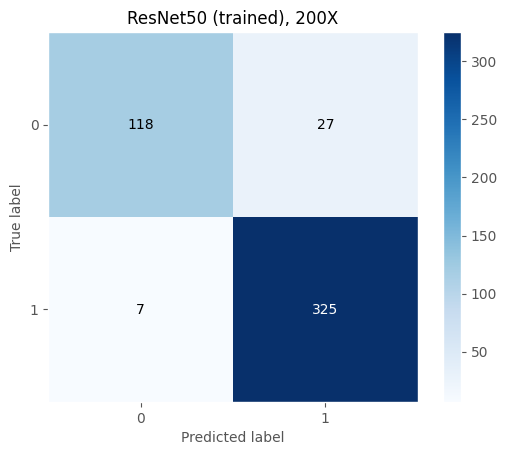

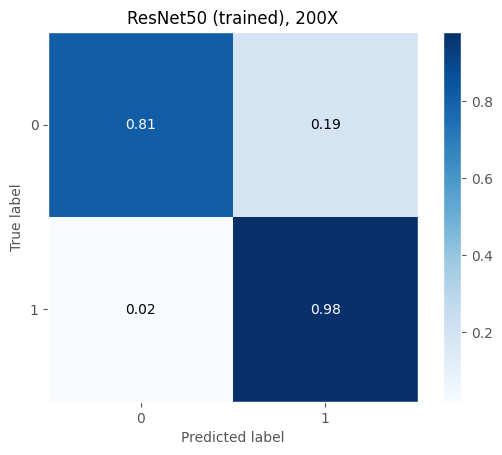

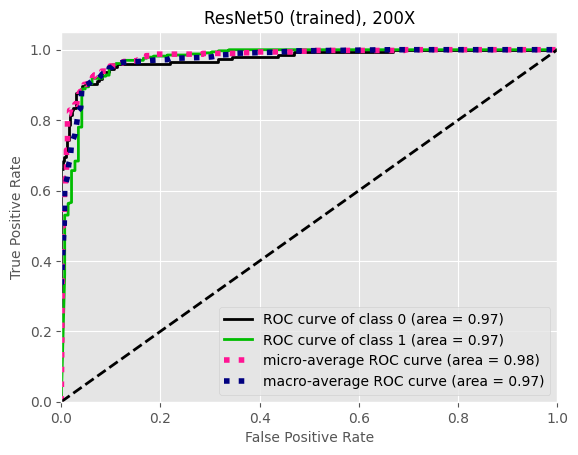

In [11]:
# Create dataset train, val, test 
train_200x, val_200x, test_200x = dataset('200/') 

folder_path_resnet50_trained_200x = "ResNet50_trained/200X/"

model = resnet50_only(train=True) 
model.summary() 

model_dataset_epoch(model, train_200x, val_200x, test_200x, epoch=30, folder_path=folder_path_resnet50_trained_200x,
                    plot_title="ResNet50 (trained), 200X") 